In [2]:
import tensorflow as tf
import cv2 
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from tensorflow.contrib.layers import layers
import glob
import os
from dice import dice
from pylab import rcParams
np.core.arrayprint._line_width = 160
rcParams['figure.figsize'] = 5, 10
os.chdir("/home/msmith/kaggle/ultraSound/")

In [3]:
def showImg(self,img):
    plt.imshow(img,cmap=cm.gray)
    plt.show()

class dataGenerator():
    def __init__(self,cvSplit=0.8,batchSize=5,inputDim=(96,128),outputDim=(12,16)):
        rng.seed(1006)
        self.trainPaths, self.testPaths = [glob.glob(s+"/*[0-9].tif") for s in ["train","test"]]
        self.batchSize = batchSize
        self.inputDim = inputDim
        self.outputDim = outputDim
        self.originalSize = (420,580)
        print("%d train paths and %d test paths" % (len(self.trainPaths),len(self.testPaths)))
        
        # Split train into CV and non CV (cross validation)
        rng.shuffle(self.trainPaths)
        cvSplitPoint = int(cvSplit*len(self.trainPaths))
        self.trainPathsCV, self.testPathsCV = self.trainPaths[:cvSplitPoint], self.trainPaths[cvSplitPoint:]
        assert len(set(self.trainPathsCV).intersection(set(self.testPathsCV))) == 0 
        
        #self.trainPathsCV = self.trainPathsCV[:500]
        #self.testPathsCV = self.testPathsCV[:100]
        
        print("Train set split into %d train CV paths and %d test CV paths" % (len(self.trainPathsCV),len(self.testPathsCV)))     


    def loadImg(self,path,CV,augment=0,method=cv2.INTER_CUBIC):
        img = cv2.imread(path,0)
        maskPath = path.replace(".tif","_mask.tif")
        if os.path.exists(path = maskPath):
            mask = cv2.imread(maskPath,0)
            maskOrig = mask.copy()
        
        if augment == 1 and CV == 1:
            rows,cols = img.shape
            
            M = cv2.getRotationMatrix2D((cols/2,rows/2),np.random.uniform(-5,5),1)
            tX, tY = np.random.randint(0,10,2)
            M[0,2] = tX
            M[1,2] = tY
            img,mask = [im[5:rows-5, 5:cols-5] for im in [img,mask]]
            img,mask = [cv2.warpAffine(im,M,(cols,rows),borderMode = 1) for im in [img,mask]]
            maskOrig = mask.copy()        
            img = cv2.resize(img,self.inputDim, interpolation = method)
            mask = cv2.resize(mask,self.outputDim, interpolation = method)
            
            return img,mask, maskOrig
        elif augment == 0 and CV == 1:
            img = cv2.resize(img,self.inputDim, interpolation = method)
            mask = cv2.resize(mask,self.outputDim, interpolation = method)
            return img,mask, maskOrig
        elif train == 0:
            img = cv2.resize(img,self.inputDim, interpolation = method)
            return img, _, _
        
    def gen(self,train):
        if train==1:
            paths = self.trainPathsCV
            rng.shuffle(paths)
            nObs = len(paths)
            augment = 1
            print("Augmenting")
            print("Training paths length =  %d" % nObs)
        elif train == 0:
            paths = self.testPathsCV
            rng.shuffle(paths)
            nObs = len(paths)
            augment = 0
            print("Not augmenting")
            print("Testing paths length =  %d" % nObs)
        self.idx = 0
        finished = 0
        while True:
            batchX = np.empty((self.batchSize,self.inputDim[0],self.inputDim[1],1))
            batchY = np.empty((self.batchSize,self.outputDim[0],self.outputDim[1],1))
            batchYOrig = np.empty((self.batchSize,self.originalSize[0],self.originalSize[1],1))
            idx = 0
            for i in range(self.idx,min(self.batchSize+self.idx,nObs)):
                x,y,yOrig = self.loadImg(paths[i],CV=1,augment=augment)
                x=x/255.0
                y=y/255.0
                yOrig=yOrig/255.0
                
                x.resize(self.inputDim[0],self.inputDim[1],1), y.resize(self.outputDim[0],self.outputDim[1],1), yOrig.resize(self.originalSize[0],self.originalSize[1],1)
                batchX[idx],batchY[idx],batchYOrig[idx] = x, y, yOrig
                idx += 1
            self.idx += self.batchSize
            if self.idx >= nObs:
                self.idx = 0
                finished = 1
            yield batchX,batchY,batchYOrig, finished 

        

In [4]:
def weights(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding="SAME")

def mp2(x):
    return tf.nn.max_pool(x,ksize = [1,2,2,1],strides=[1,2,2,1],padding="SAME")

In [5]:
tf.reset_default_graph() 
with tf.variable_scope("deCnn"):
    inputDim, outputDim = (128,128), (8,8)
    x = tf.placeholder(tf.float32,shape=[None,inputDim[0],inputDim[1],1])
    y_ = tf.placeholder(tf.float32,shape=[None,outputDim[0],outputDim[1],1])

    convolutionLayers = []
    nConvolutions = 5
    nFeatsOut = 16
    nFeatsInc = 8
    for i in xrange(nConvolutions):
        if i ==0:
            nFeatsIn = 1
        elif i < nConvolutions - 1:
            nFeatsOut += nFeatsInc
        elif i == nConvolutions-1:
            nFeatsOut = 1

        W = weights([3,3,nFeatsIn,nFeatsOut])
        b = bias([nFeatsOut])
        convolutionLayers.append([W,b]) 
        nFeatsIn = nFeatsOut
        
    h1 = conv2d(x,convolutionLayers[0][0]) + convolutionLayers[0][1]
    h1_bn = tf.nn.relu(layers.batch_norm(h1))
    h1p = mp2(h1_bn)
    
    h2 = conv2d(h1p,convolutionLayers[1][0]) + convolutionLayers[1][1]
    h2_bn = tf.nn.relu(layers.batch_norm(h2))
    h2p = mp2(h2_bn)
    
    h3 = conv2d(h2p,convolutionLayers[2][0]) + convolutionLayers[2][1]
    h3_bn = tf.nn.relu(layers.batch_norm(h3))
    h3p = mp2(h3_bn)
    
    h4 = tf.nn.relu(conv2d(h3p,convolutionLayers[3][0]) + convolutionLayers[3][1])
    h4_bn = tf.nn.relu(layers.batch_norm(h4))
    h4p = mp2(h4_bn)
    
    #h5 = tf.nn.relu(conv2d(h4p,convolutionLayers[4][0]) + convolutionLayers[4][1])
    #h5_bn = tf.nn.relu(layers.batch_norm(h5))
    #h5p = mp2(h5_bn)
    h5_bn = layers.batch_norm(conv2d(h4p,convolutionLayers[4][0]) + convolutionLayers[4][1])
    
    yPred = tf.nn.sigmoid(h5_bn)

print(x.get_shape())
for i in xrange(len(convolutionLayers)):
    print(convolutionLayers[i][0].get_shape())

(?, 128, 128, 1)
(3, 3, 1, 16)
(3, 3, 16, 24)
(3, 3, 24, 32)
(3, 3, 32, 40)
(3, 3, 40, 1)


In [9]:
class performance():
    def __init__(self):
        self.epochLosses = []
        self.epochScores = []
        self.losses = []
        self.scores = []
    def add(self,loss,score):
        self.losses.append(loss)
        self.scores.append(score)
    def endEpoch(self):
        self.epochLosses.append(np.array(self.losses).mean())
        self.epochScores.append(np.array(self.scores).mean())
        self.losses = []
        self.scores = []
        


5635 train paths and 5508 test paths
Train set split into 4508 train CV paths and 1127 test CV paths
Augmenting
Training paths length =  4508
Seen 2000 examples


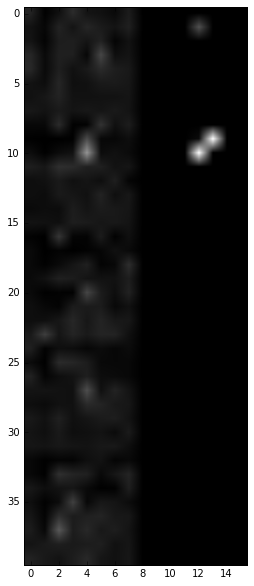

Seen 4000 examples


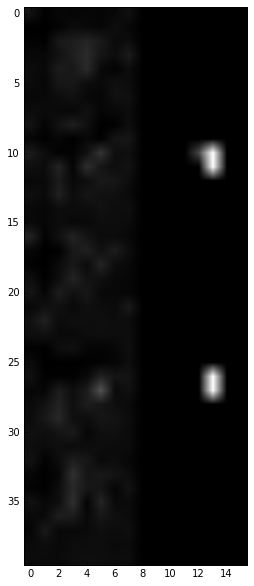

Not augmenting
Testing paths length =  1127
Finished epoch 0. Current mean loss and scores for train test are ==>
([0.42463011], [0.27383068])
([0.15321796], [0.33556703])
Augmenting
Training paths length =  4508
Seen 2000 examples


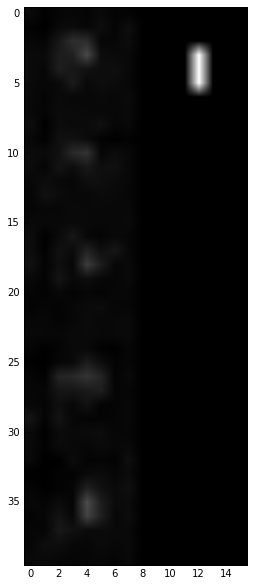

Seen 4000 examples


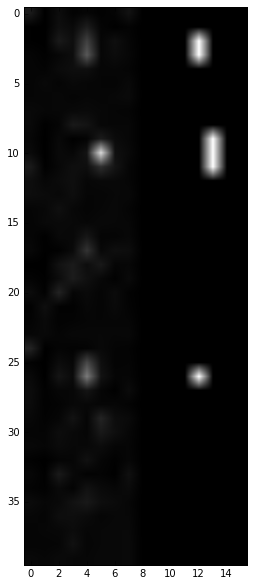

Not augmenting
Testing paths length =  1127
Finished epoch 1. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311], [0.27383068, 0.37649456])
([0.15321796, 0.12725361], [0.33556703, 0.39201662])
Augmenting
Training paths length =  4508
Seen 2000 examples


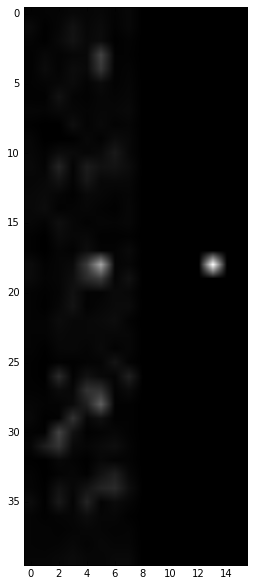

Seen 4000 examples


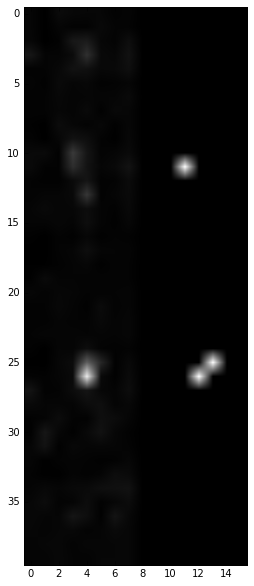

Not augmenting
Testing paths length =  1127
Finished epoch 2. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194], [0.27383068, 0.37649456, 0.43023977])
([0.15321796, 0.12725361, 0.11677668], [0.33556703, 0.39201662, 0.43587095])
Augmenting
Training paths length =  4508
Seen 2000 examples


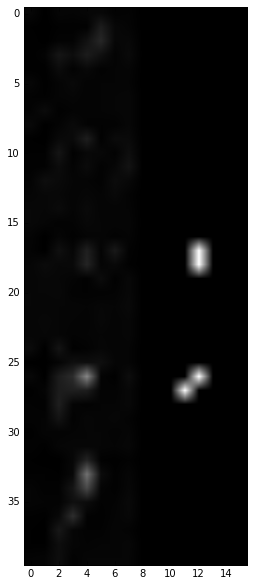

Seen 4000 examples


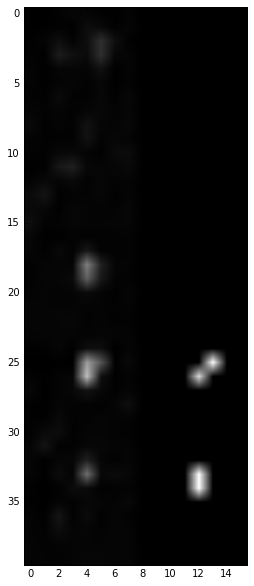

Not augmenting
Testing paths length =  1127
Finished epoch 3. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561], [0.27383068, 0.37649456, 0.43023977, 0.45243758])
([0.15321796, 0.12725361, 0.11677668, 0.11146168], [0.33556703, 0.39201662, 0.43587095, 0.50128841])
Augmenting
Training paths length =  4508
Seen 2000 examples


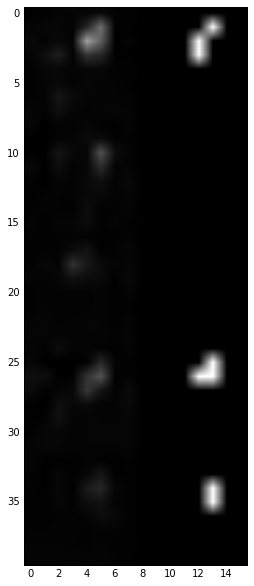

Seen 4000 examples


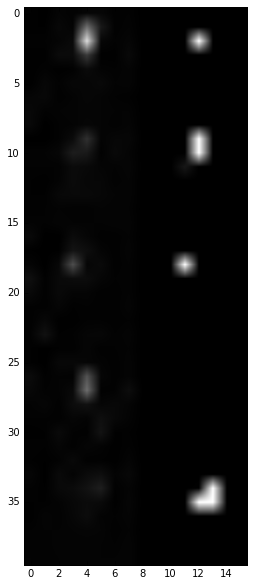

Not augmenting
Testing paths length =  1127
Finished epoch 4. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312])
Augmenting
Training paths length =  4508
Seen 2000 examples


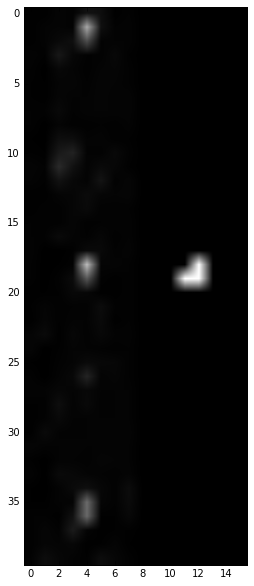

Seen 4000 examples


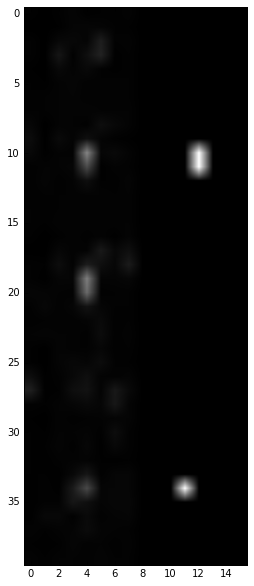

Not augmenting
Testing paths length =  1127
Finished epoch 5. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306])
Augmenting
Training paths length =  4508
Seen 2000 examples


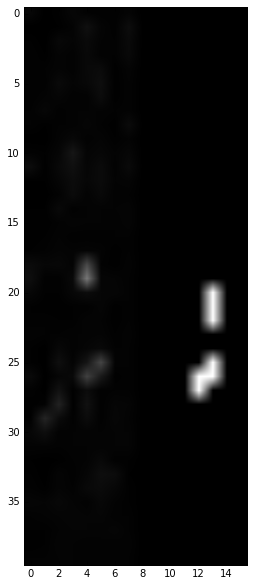

Seen 4000 examples


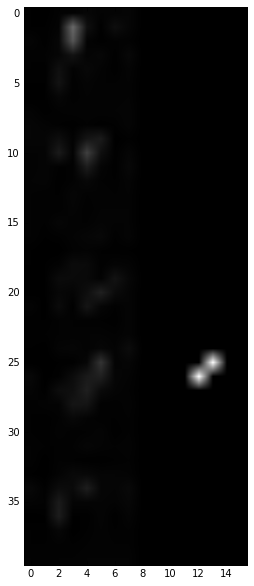

Not augmenting
Testing paths length =  1127
Finished epoch 6. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516])
Augmenting
Training paths length =  4508
Seen 2000 examples


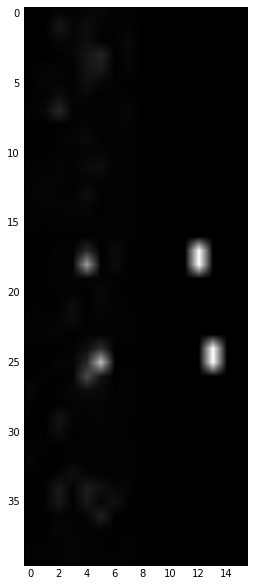

Seen 4000 examples


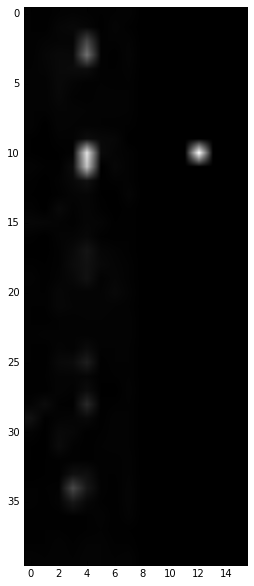

Not augmenting
Testing paths length =  1127
Finished epoch 7. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769])
Augmenting
Training paths length =  4508
Seen 2000 examples


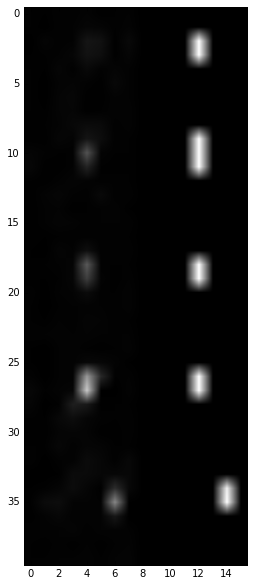

Seen 4000 examples


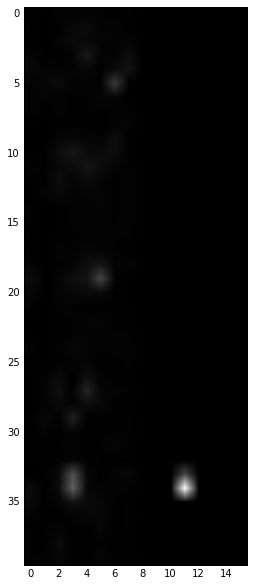

Not augmenting
Testing paths length =  1127
Finished epoch 8. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459])
Augmenting
Training paths length =  4508
Seen 2000 examples


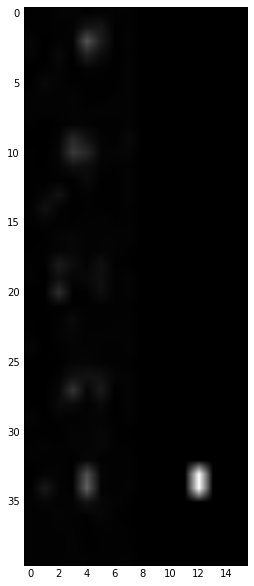

Seen 4000 examples


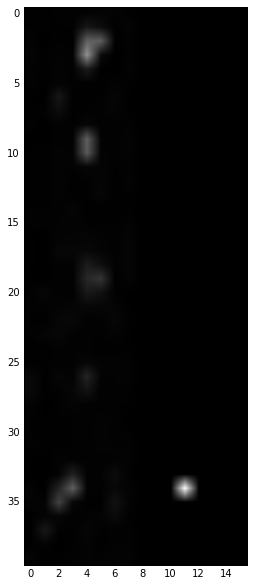

Not augmenting
Testing paths length =  1127
Finished epoch 9. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459, 0.54752058])
Augmenting
Training paths length =  4508
Seen 2000 examples


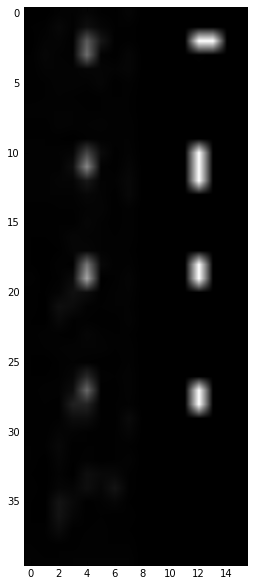

Seen 4000 examples


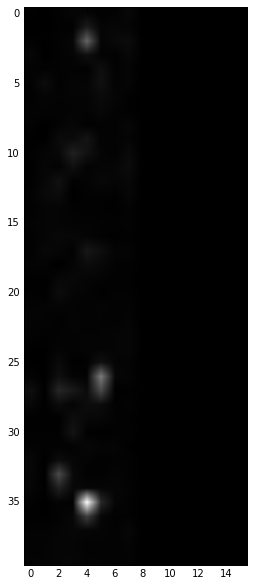

Not augmenting
Testing paths length =  1127
Finished epoch 10. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459, 0.54752058, 0.55221564])
Augmenting
Training paths length =  4508
Seen 2000 examples


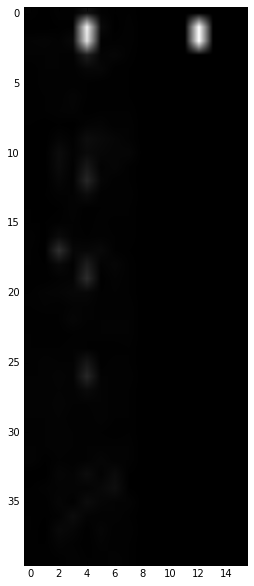

Seen 4000 examples


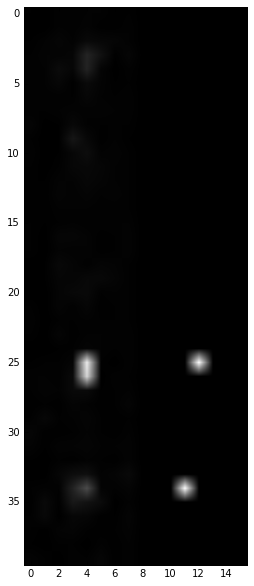

Not augmenting
Testing paths length =  1127
Finished epoch 11. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459, 0.54752058, 0.55221564, 0.5488674])
Augmenting
Training paths length =  4508
Seen 2000 examples


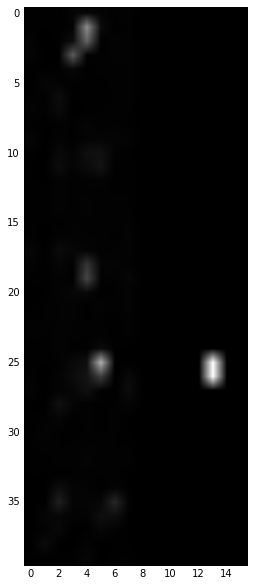

Seen 4000 examples


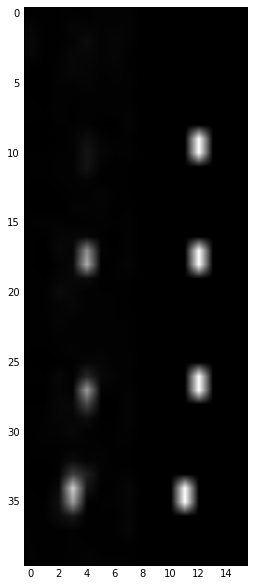

Not augmenting
Testing paths length =  1127
Finished epoch 12. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459, 0.54752058, 0.55221564, 0.5488674, 0.54602855])
Augmenting
Training paths length =  4508
Seen 2000 examples


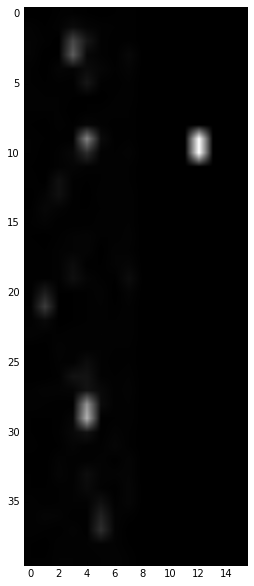

Seen 4000 examples


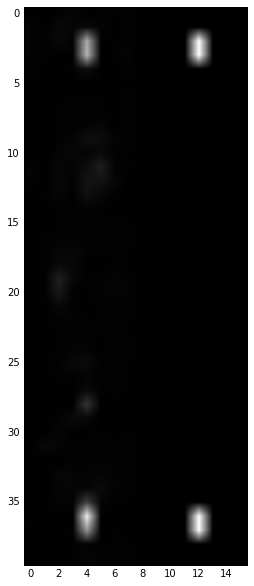

Not augmenting
Testing paths length =  1127
Finished epoch 13. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459, 0.54752058, 0.55221564, 0.5488674, 0.54602855, 0.53305393])
Augmenting
Training paths length =  4508
Seen 2000 examples


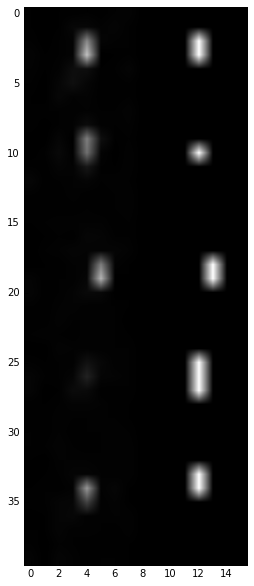

Seen 4000 examples


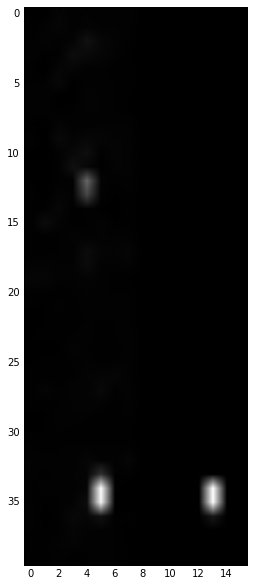

Not augmenting
Testing paths length =  1127
Finished epoch 14. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459, 0.54752058, 0.55221564, 0.5488674, 0.54602855, 0.53305393, 0.54822099])
Augmenting
Training paths length =  4508
Seen 2000 examples


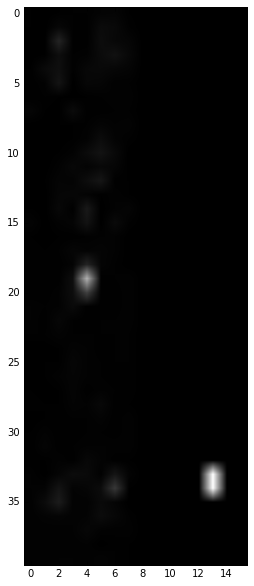

Seen 4000 examples


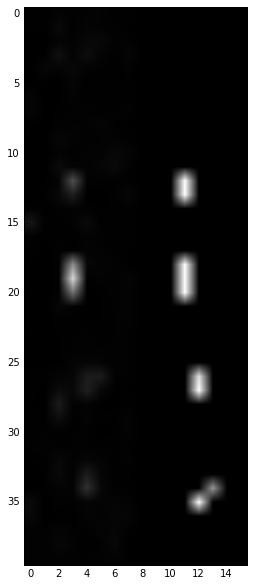

Not augmenting
Testing paths length =  1127
Finished epoch 15. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459, 0.54752058, 0.55221564, 0.5488674, 0.54602855, 0.53305393, 0.54822099, 0.54020673])
Augmenting
Training paths length =  4508
Seen 2000 examples


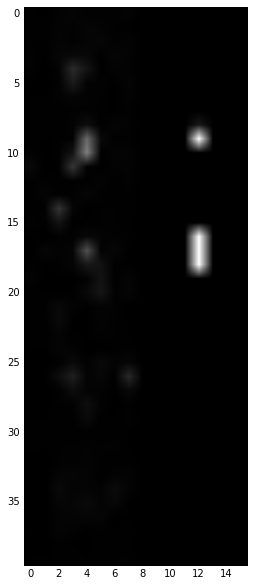

Seen 4000 examples


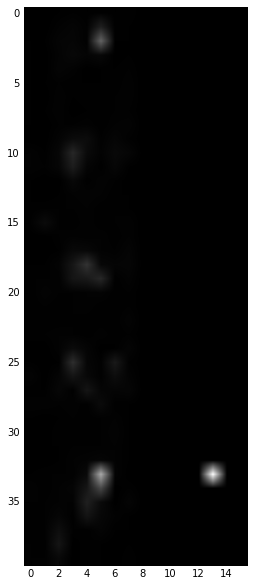

Not augmenting
Testing paths length =  1127
Finished epoch 16. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847, 0.094154276], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459, 0.54752058, 0.55221564, 0.5488674, 0.54602855, 0.53305393, 0.54822099, 0.54020673, 0.56688696])
Augmenting
Training paths length =  4508
Seen 2000

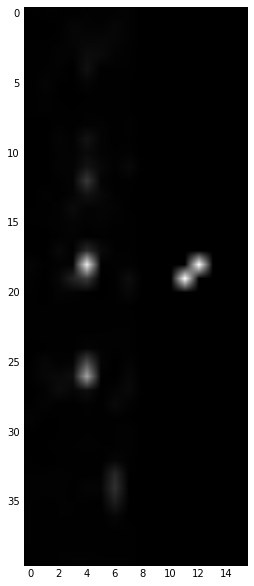

Seen 4000 examples


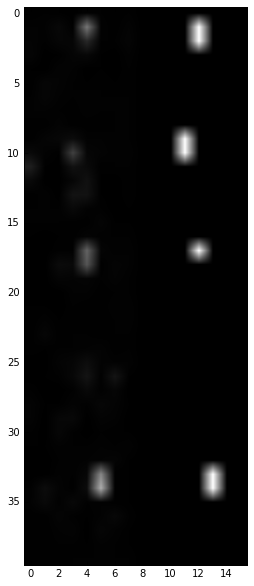

Not augmenting
Testing paths length =  1127
Finished epoch 17. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847, 0.094154276, 0.09336517], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459, 0.54752058, 0.55221564, 0.5488674, 0.54602855, 0.53305393, 0.54822099, 0.54020673, 0.56688696, 0.55027467])
Au

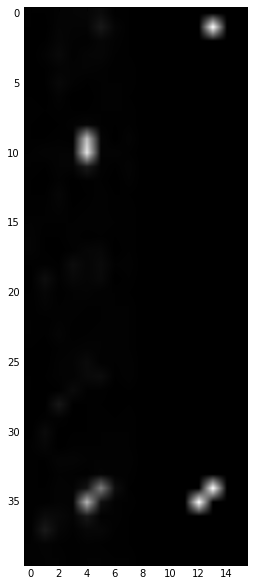

Seen 4000 examples


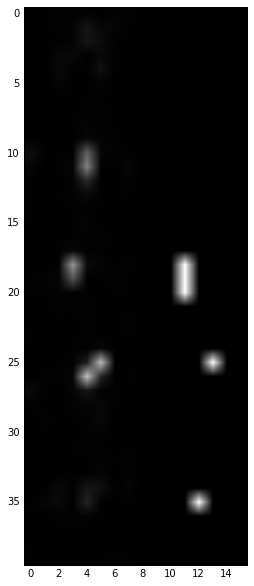

Not augmenting
Testing paths length =  1127
Finished epoch 18. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847, 0.094154276, 0.09336517, 0.093343936], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459, 0.54752058, 0.55221564, 0.5488674, 0.54602855, 0.53305393, 0.54822099, 0

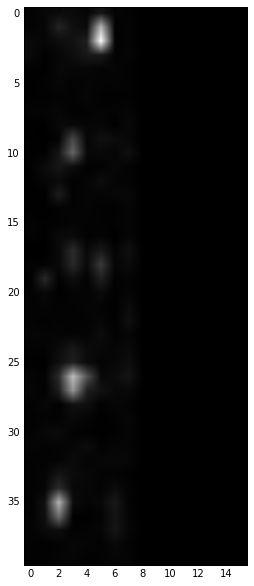

Seen 4000 examples


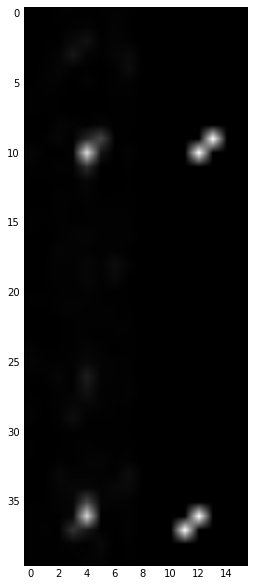

Not augmenting
Testing paths length =  1127
Finished epoch 19. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847, 0.094154276, 0.09336517, 0.093343936, 0.09437985], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.54358459, 0.54752058, 0.55221564, 0.5488674, 

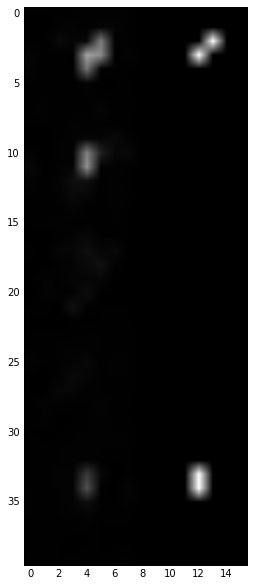

Seen 4000 examples


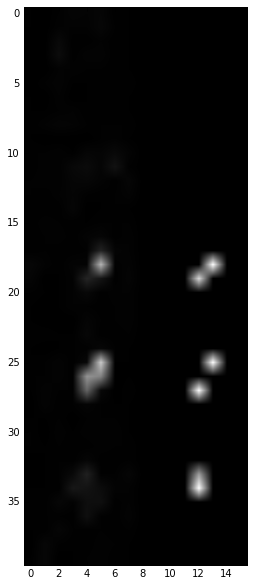

Not augmenting
Testing paths length =  1127
Finished epoch 20. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847, 0.094154276, 0.09336517, 0.093343936, 0.09437985, 0.095678248], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.52367306, 0.51631516, 0.52884769, 0.5435845

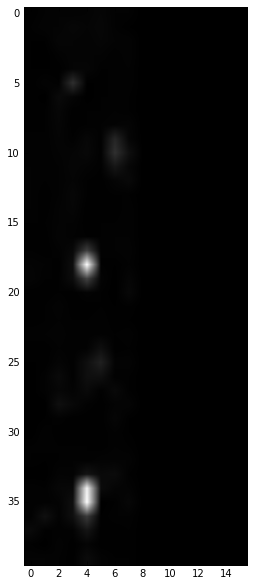

Seen 4000 examples


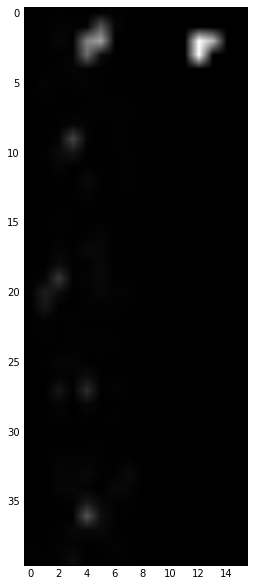

Not augmenting
Testing paths length =  1127
Finished epoch 21. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847, 0.094154276, 0.09336517, 0.093343936, 0.09437985, 0.095678248, 0.092535377], [0.33556703, 0.39201662, 0.43587095, 0.50128841, 0.4973312, 0.523673

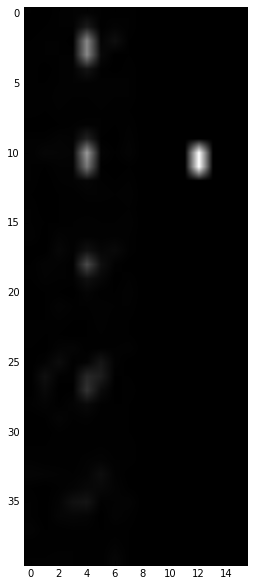

Seen 4000 examples


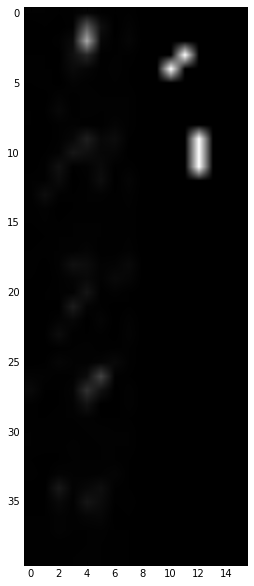

Not augmenting
Testing paths length =  1127
Finished epoch 22. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847, 0.094154276, 0.09336517, 0.093343936, 0.09437985, 0.095678248, 0.092535377, 0.091410369], [0.33556703, 0.39201662, 0.435

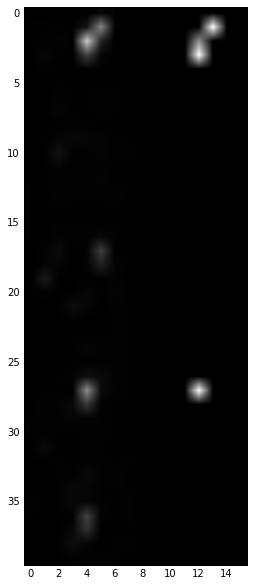

Seen 4000 examples


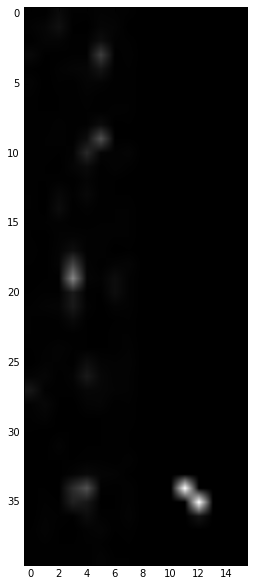

Not augmenting
Testing paths length =  1127
Finished epoch 23. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847, 0.094154276, 0.09336517, 0.093343936, 0.09437985, 0.095678248, 0.092535377, 0.091410369, 0.0924

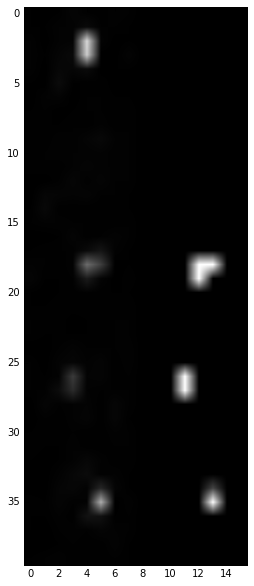

Seen 4000 examples


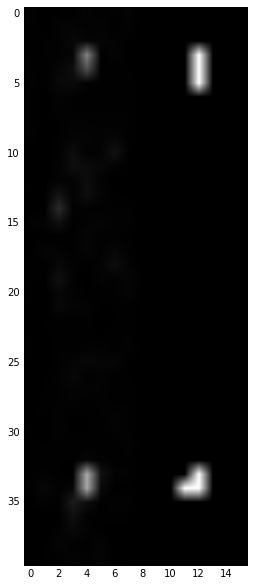

Not augmenting
Testing paths length =  1127
Finished epoch 24. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847, 0.094154276, 0.09336517, 0.093343936, 0.09437985, 0.095678248, 0.09253

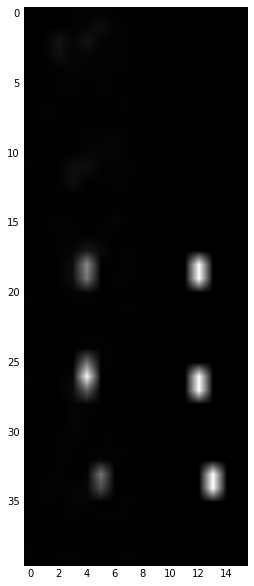

Seen 4000 examples


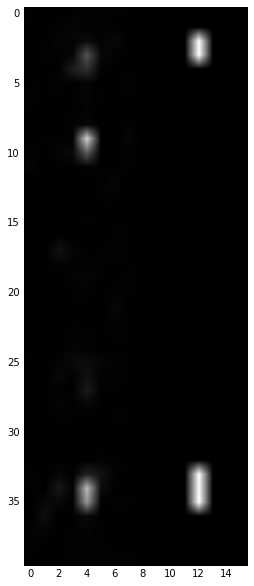

Not augmenting
Testing paths length =  1127
Finished epoch 25. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847, 0.094154276, 0.09336517, 0.093343936, 0.09437

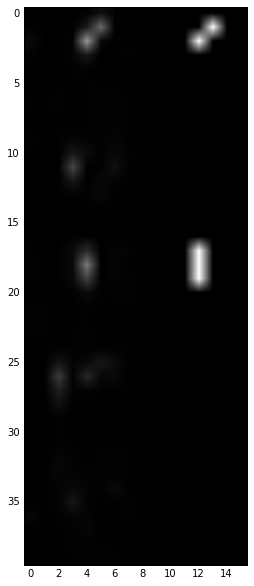

Seen 4000 examples


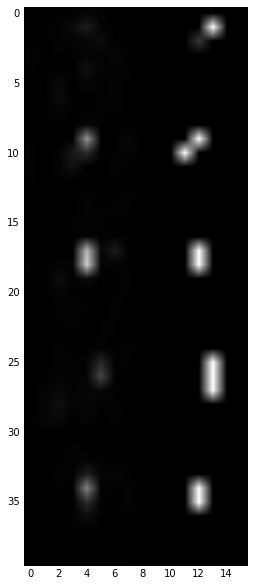

Not augmenting
Testing paths length =  1127
Finished epoch 26. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420847, 0.094154276, 0.09336

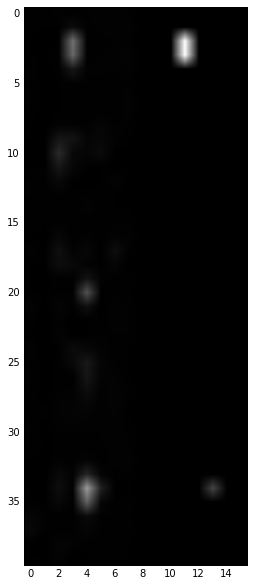

Seen 4000 examples


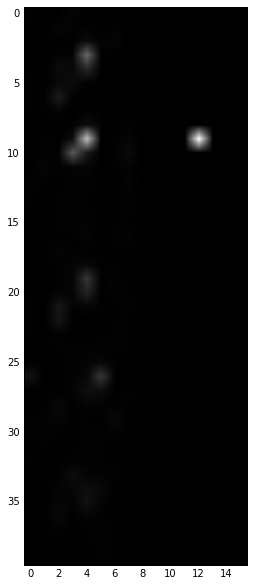

Not augmenting
Testing paths length =  1127
Finished epoch 27. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.095959768, 0.095857807, 0.096420

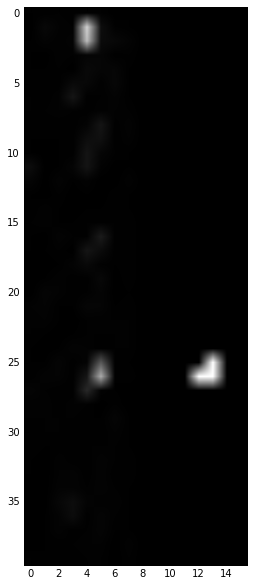

Seen 4000 examples


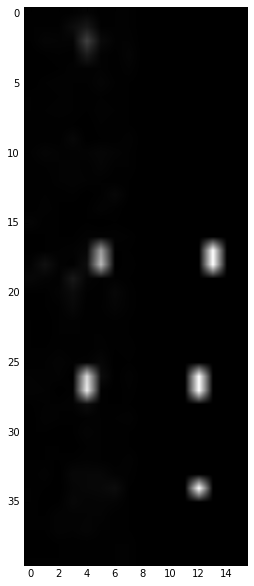

Not augmenting
Testing paths length =  1127
Finished epoch 28. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.096450739, 0.09650109, 0.0959597

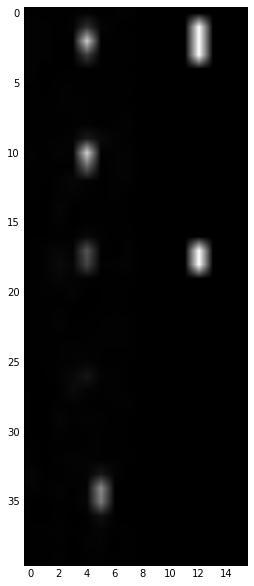

Seen 4000 examples


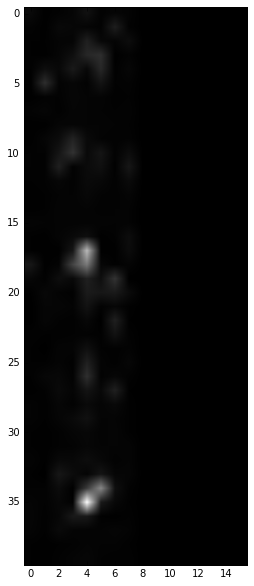

Not augmenting
Testing paths length =  1127
Finished epoch 29. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 0.097700112, 0.09645073

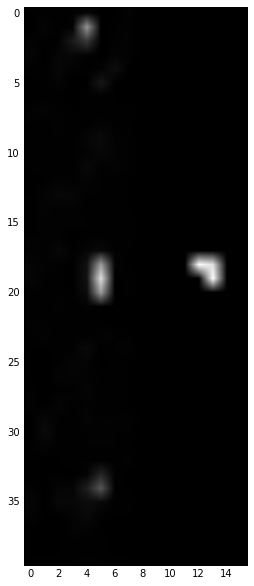

Seen 4000 examples


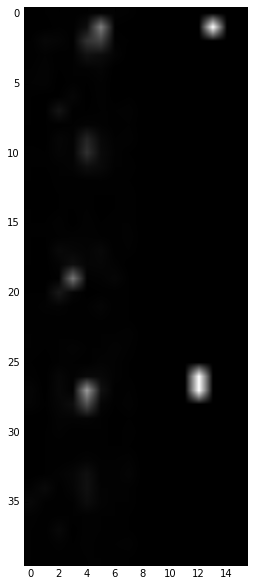

Not augmenting
Testing paths length =  1127
Finished epoch 30. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894, 0.581496])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0.099211179, 0.098937564, 

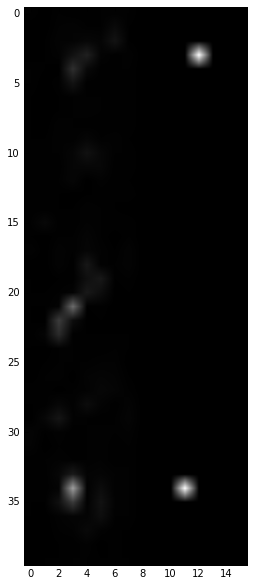

Seen 4000 examples


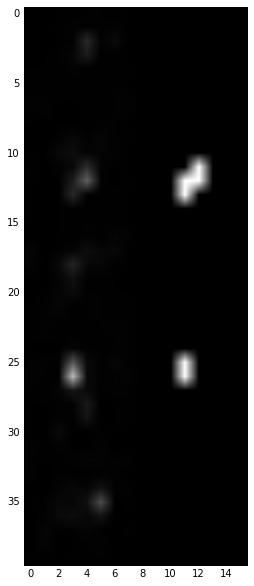

Not augmenting
Testing paths length =  1127
Finished epoch 31. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894, 0.581496, 0.57461894])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 0.10224824, 0.09986192, 0

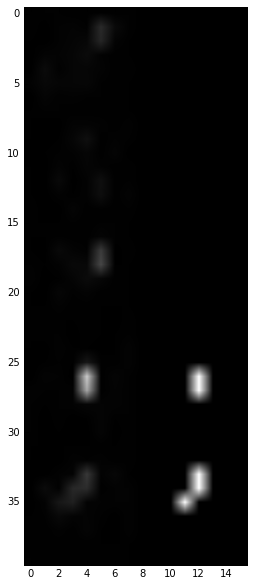

Seen 4000 examples


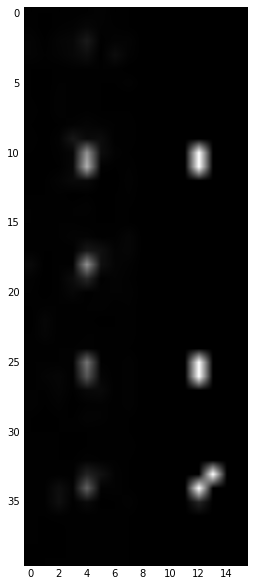

Not augmenting
Testing paths length =  1127
Finished epoch 32. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894, 0.581496, 0.57461894, 0.58529395])
([0.15321796, 0.12725361, 0.11677668, 0.11146168, 0.1075117, 0.10401039, 

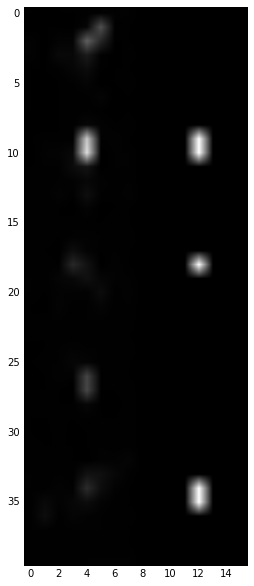

Seen 4000 examples


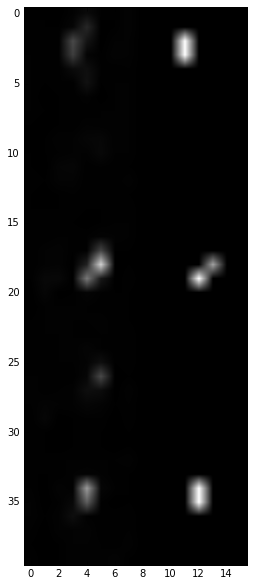

Not augmenting
Testing paths length =  1127
Finished epoch 33. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894, 0.581496, 0.57461894, 0.58529395, 0.5745399])
([0.15321796, 0.12725361, 0.11677668, 0.11146168,

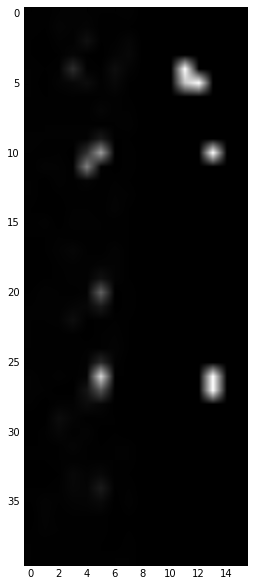

Seen 4000 examples


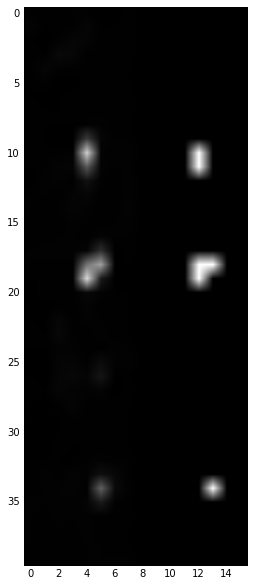

Not augmenting
Testing paths length =  1127
Finished epoch 34. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894, 0.581496, 0.57461894, 0.58529395, 0.5745399, 0.6045121])
([0.15321796, 0.12725361,

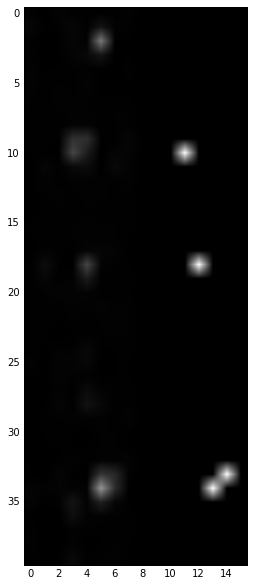

Seen 4000 examples


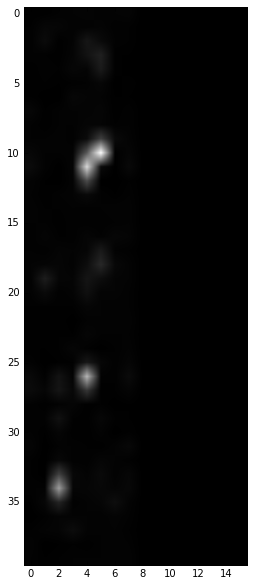

Not augmenting
Testing paths length =  1127
Finished epoch 35. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894, 0.581496, 0.57461894, 0.58529395, 0.5745399, 0.6045121, 0.59424818])
(

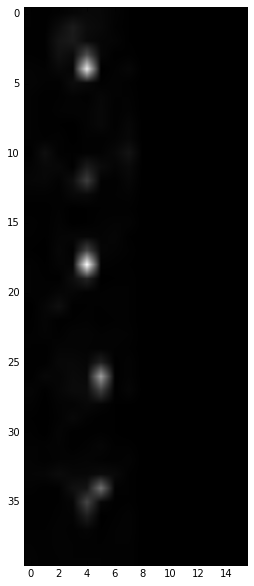

Seen 4000 examples


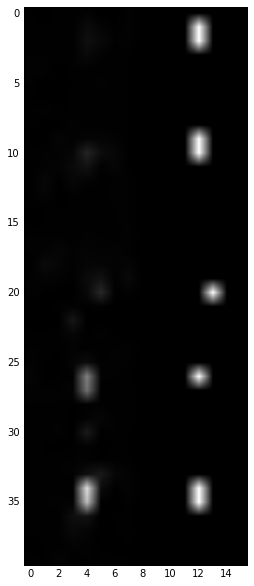

Not augmenting
Testing paths length =  1127
Finished epoch 36. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894, 0.581496, 0.57461894, 0.58529395, 0.5745399, 0.6045121, 0

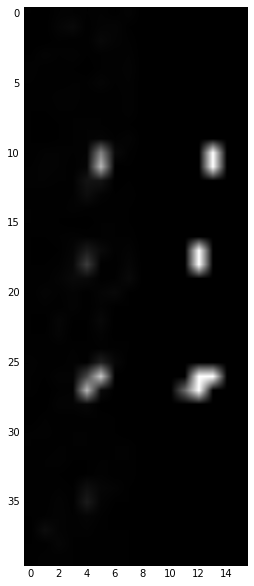

Seen 4000 examples


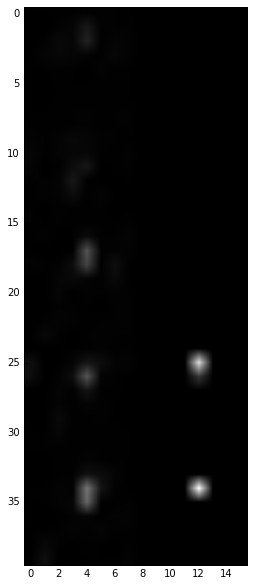

Not augmenting
Testing paths length =  1127
Finished epoch 37. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894, 0.581496, 0.57461894, 0.58529395, 0.5745399,

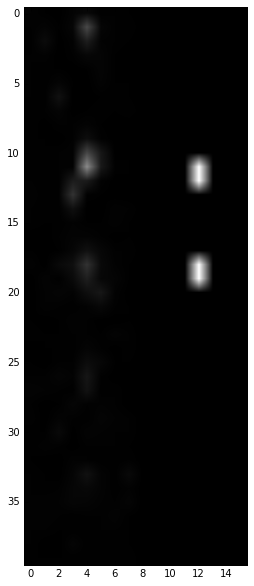

Seen 4000 examples


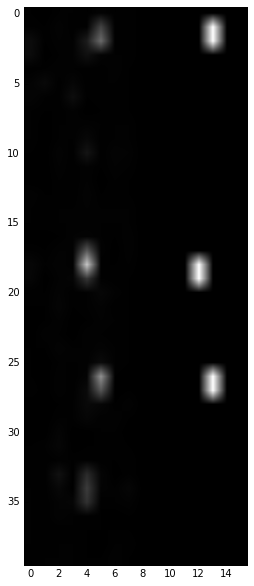

Not augmenting
Testing paths length =  1127
Finished epoch 38. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894, 0.581496, 0.57461894, 0.5852939

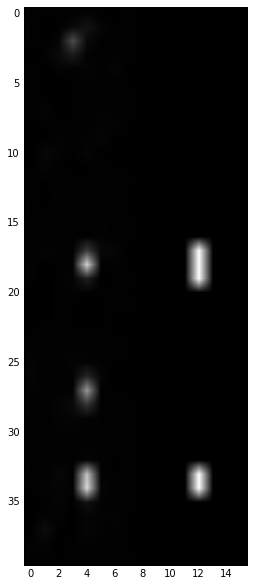

Seen 4000 examples


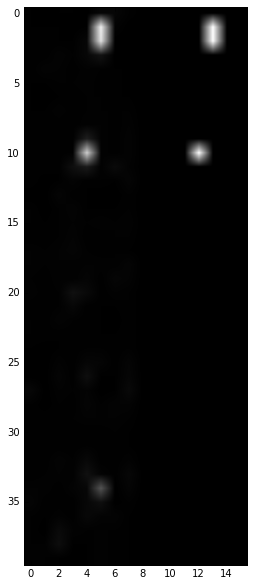

Not augmenting
Testing paths length =  1127
Finished epoch 39. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894, 0.581496, 0.574618

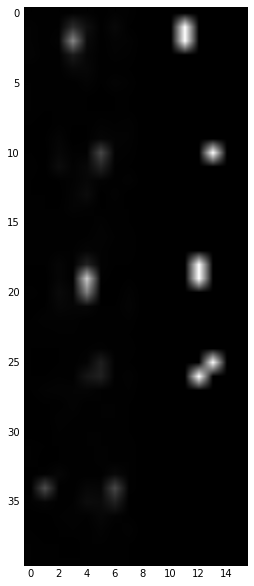

Seen 4000 examples


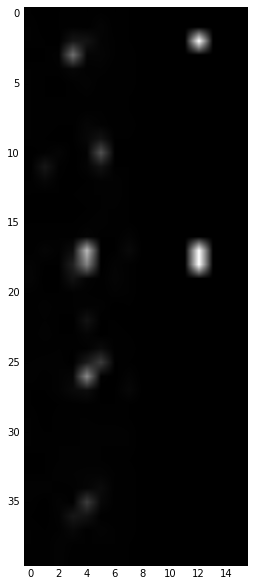

Not augmenting
Testing paths length =  1127
Finished epoch 40. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.5851894, 0.581

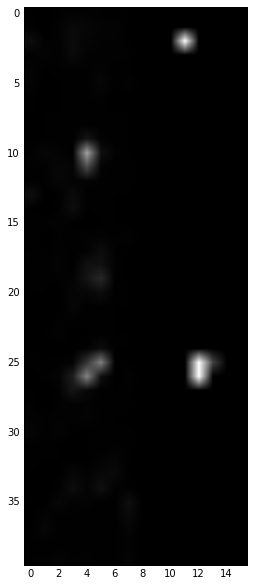

Seen 4000 examples


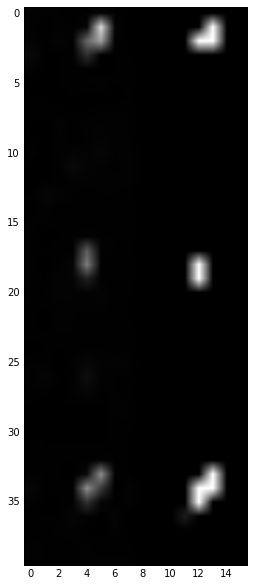

Not augmenting
Testing paths length =  1127
Finished epoch 41. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.58158886, 0.58

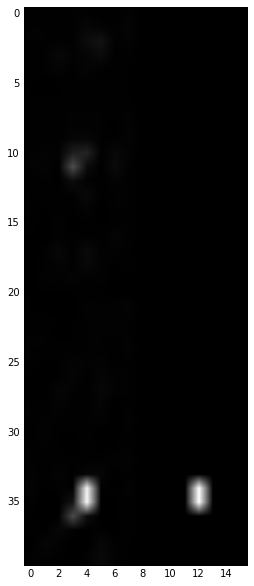

Seen 4000 examples


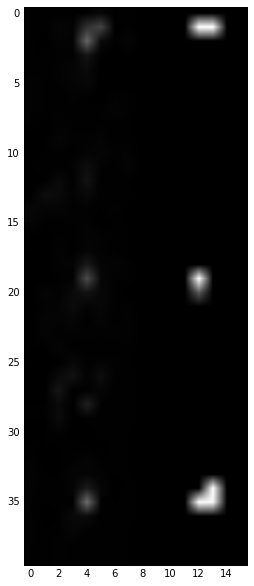

Not augmenting
Testing paths length =  1127
Finished epoch 42. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.57054299, 0.5

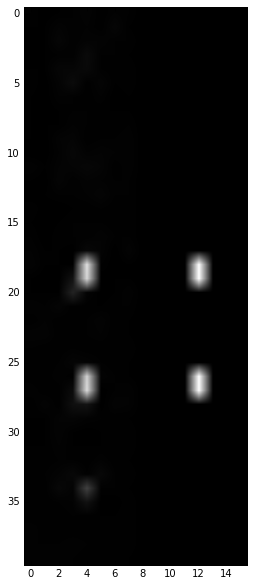

Seen 4000 examples


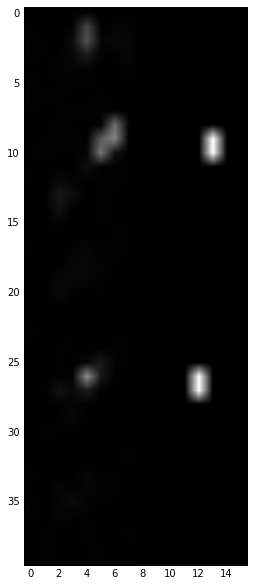

Not augmenting
Testing paths length =  1127
Finished epoch 43. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0.57500917, 0.

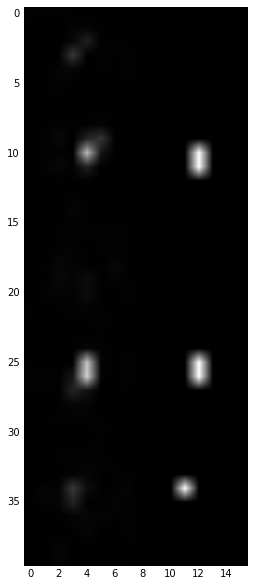

Seen 4000 examples


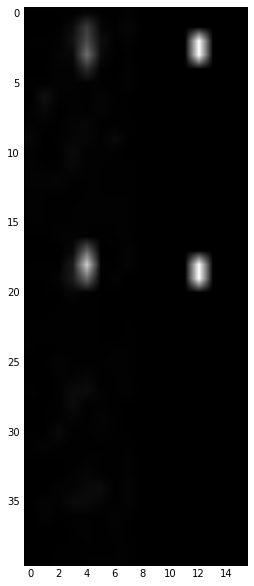

Not augmenting
Testing paths length =  1127
Finished epoch 44. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 0.57697445, 0

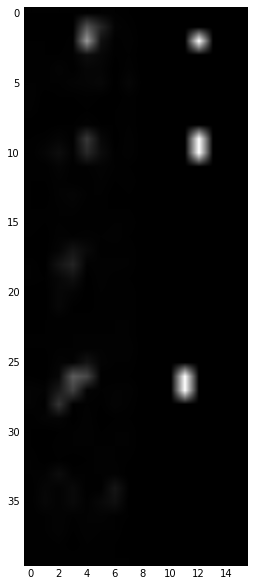

Seen 4000 examples


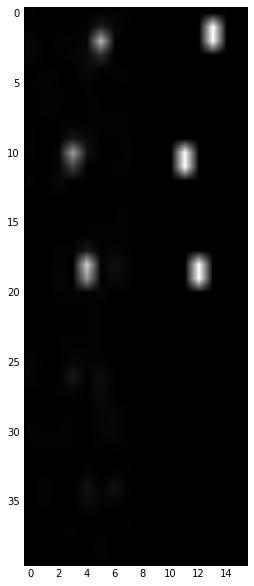

Not augmenting
Testing paths length =  1127
Finished epoch 45. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186, 0.57823145, 

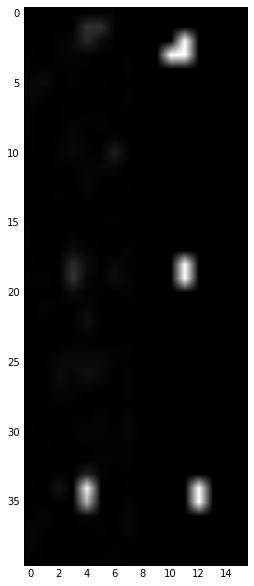

Seen 4000 examples


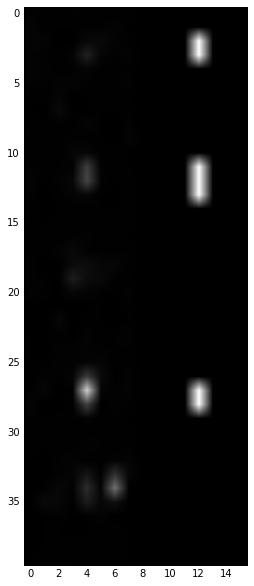

Not augmenting
Testing paths length =  1127
Finished epoch 46. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925, 0.56782186,

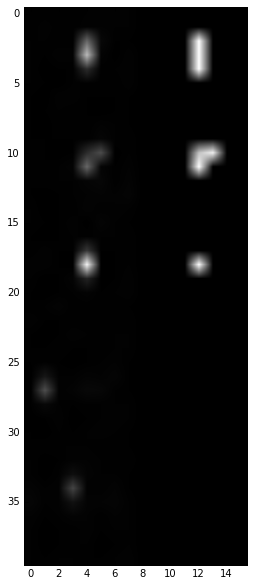

Seen 4000 examples


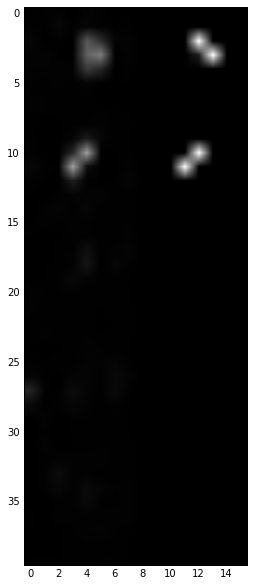

Not augmenting
Testing paths length =  1127
Finished epoch 47. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.5563997, 0.57186925

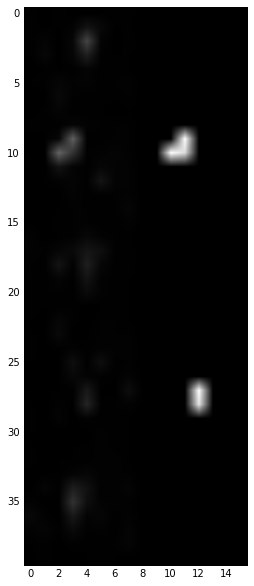

Seen 4000 examples


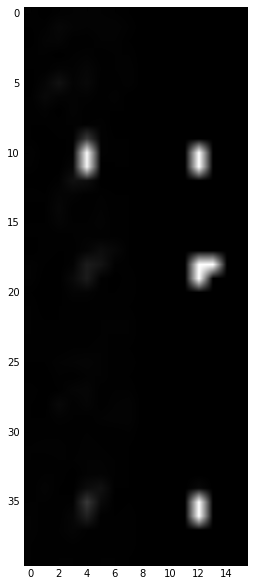

Not augmenting
Testing paths length =  1127
Finished epoch 48. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348824, 0.556399

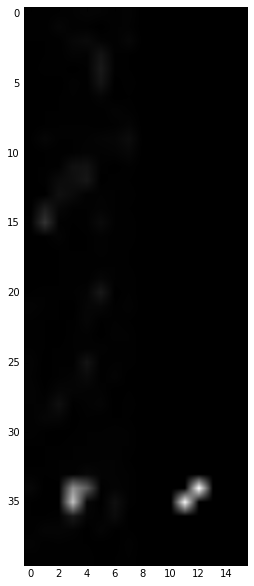

Seen 4000 examples


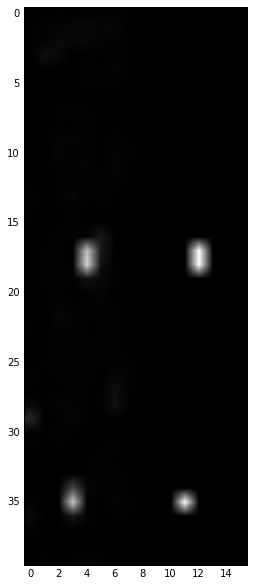

Not augmenting
Testing paths length =  1127
Finished epoch 49. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473302, 0.57348

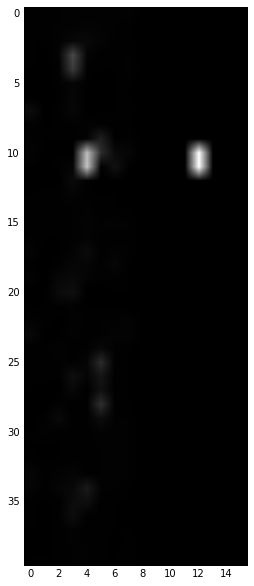

Seen 4000 examples


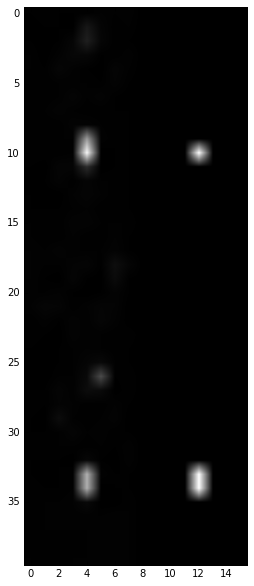

Not augmenting
Testing paths length =  1127
Finished epoch 50. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.55578411, 0.57473

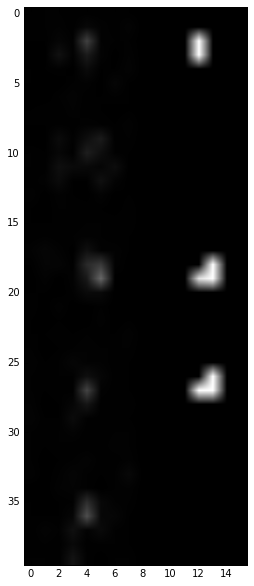

Seen 4000 examples


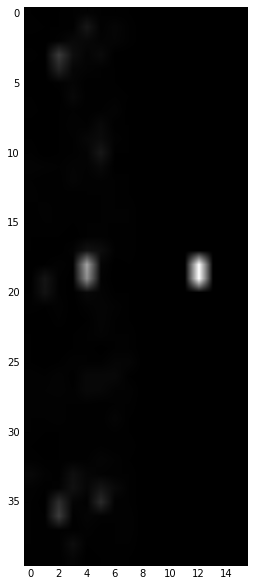

Not augmenting
Testing paths length =  1127
Finished epoch 51. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.56998742, 0.5557

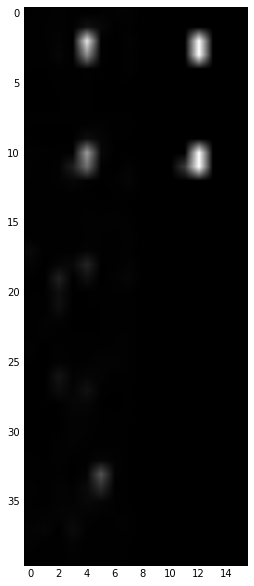

Seen 4000 examples


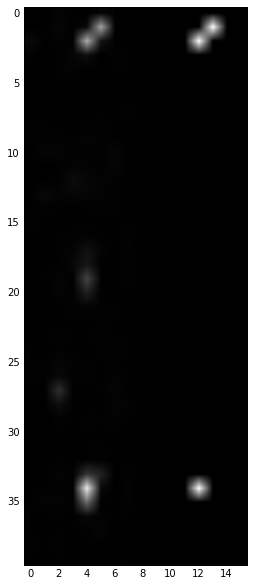

Not augmenting
Testing paths length =  1127
Finished epoch 52. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56139094, 0.569

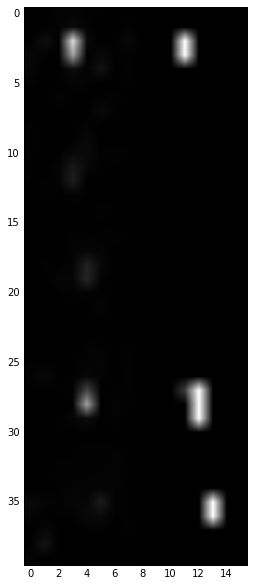

Seen 4000 examples


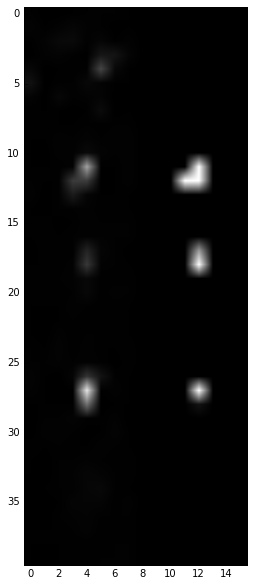

Not augmenting
Testing paths length =  1127
Finished epoch 53. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.56053191, 0.56

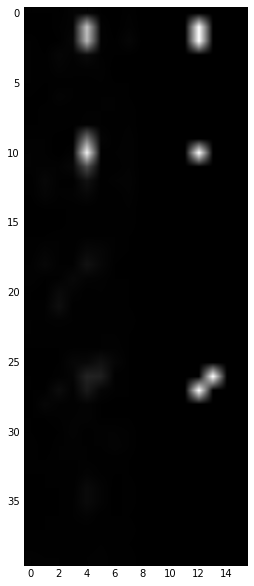

Seen 4000 examples


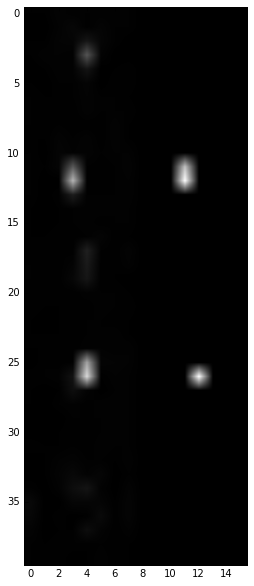

Not augmenting
Testing paths length =  1127
Finished epoch 54. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.55225176, 0.5

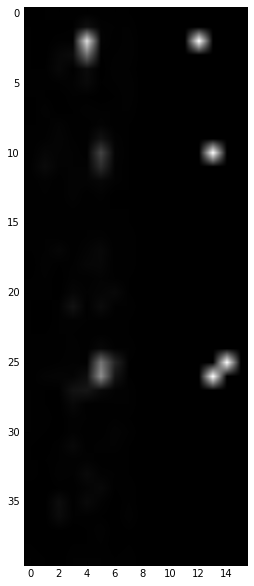

Seen 4000 examples


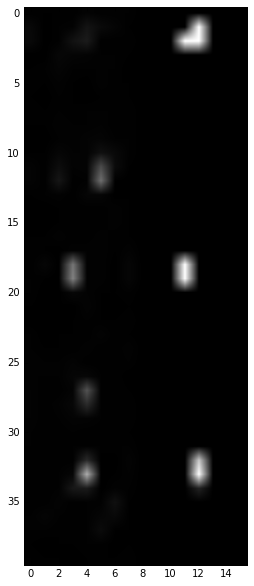

Not augmenting
Testing paths length =  1127
Finished epoch 55. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0.55301964, 0.

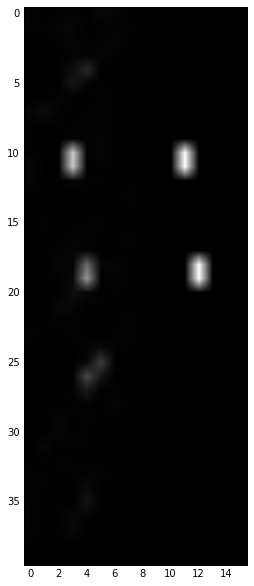

Seen 4000 examples


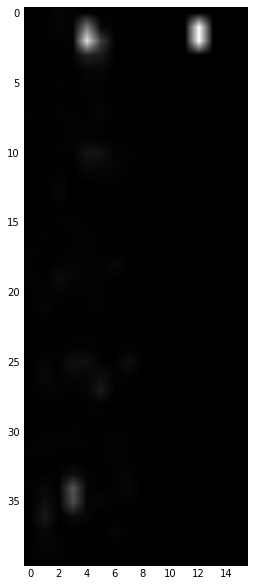

Not augmenting
Testing paths length =  1127
Finished epoch 56. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 0.5429976, 0

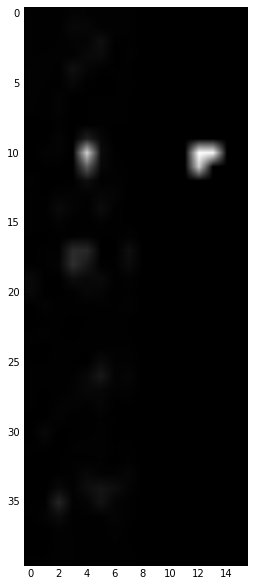

Seen 4000 examples


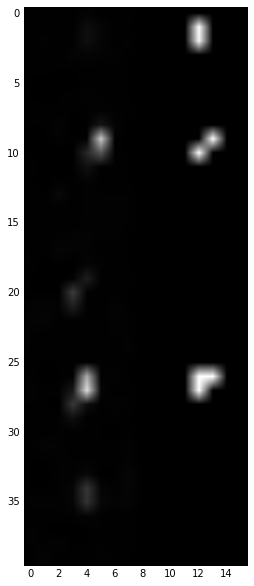

Not augmenting
Testing paths length =  1127
Finished epoch 57. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179, 0.08461269], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253, 0.55206716, 

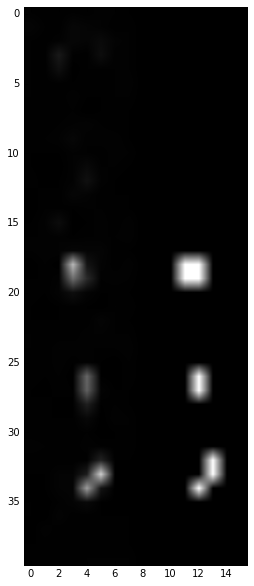

Seen 4000 examples


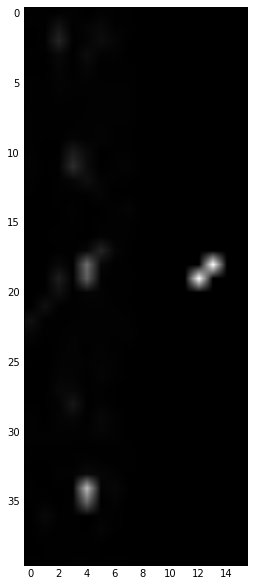

Not augmenting
Testing paths length =  1127
Finished epoch 58. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179, 0.08461269, 0.084140092], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405, 0.54834253,

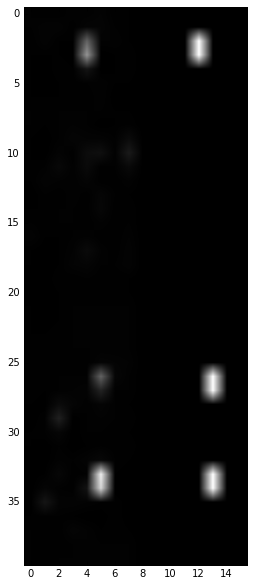

Seen 4000 examples


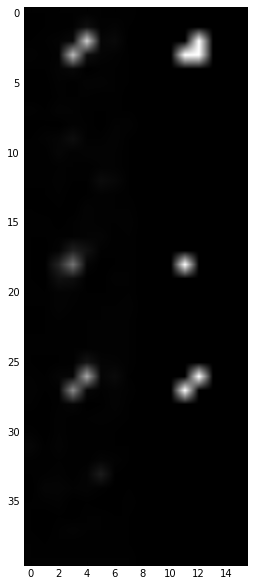

Not augmenting
Testing paths length =  1127
Finished epoch 59. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179, 0.08461269, 0.084140092, 0.08463411], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093, 0.53476405,

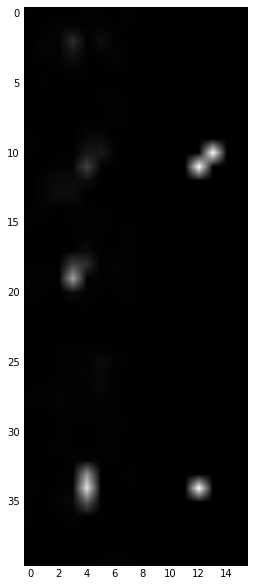

Seen 4000 examples


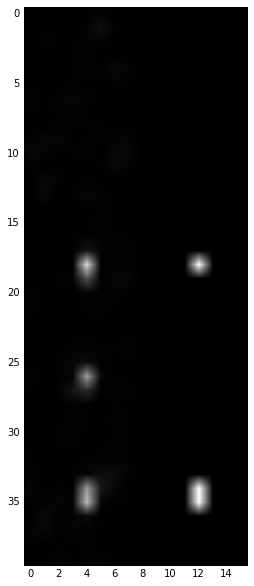

Not augmenting
Testing paths length =  1127
Finished epoch 60. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179, 0.08461269, 0.084140092, 0.08463411, 0.082187846], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.52868879, 0.52684093

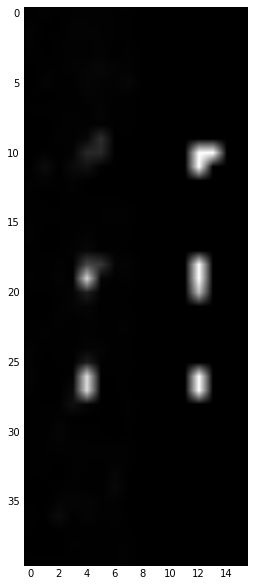

Seen 4000 examples


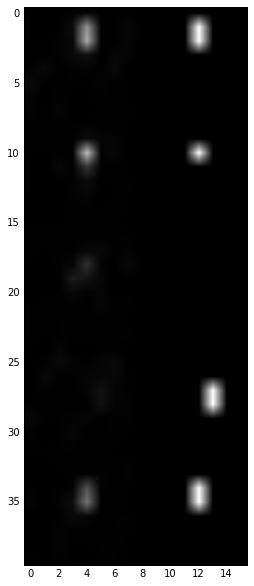

Not augmenting
Testing paths length =  1127
Finished epoch 61. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179, 0.08461269, 0.084140092, 0.08463411, 0.082187846, 0.083690181], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.50717127, 0.5286887

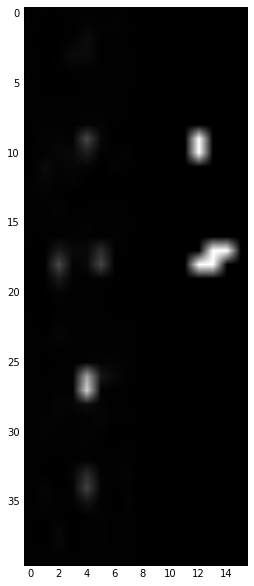

Seen 4000 examples


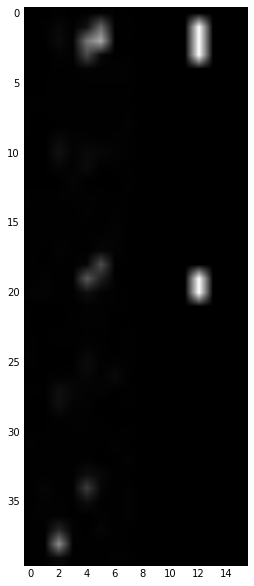

Not augmenting
Testing paths length =  1127
Finished epoch 62. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179, 0.08461269, 0.084140092, 0.08463411, 0.082187846, 0.083690181, 0.082818992], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370353, 0.507171

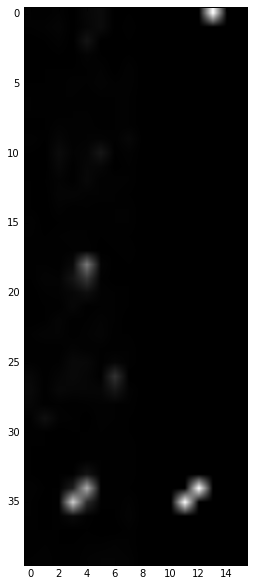

Seen 4000 examples


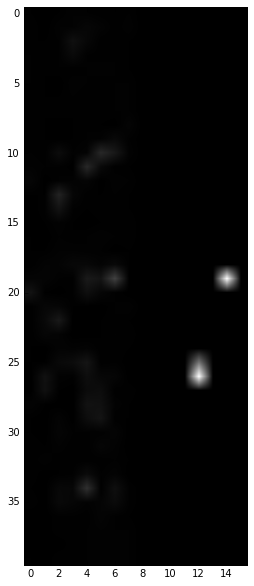

Not augmenting
Testing paths length =  1127
Finished epoch 63. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179, 0.08461269, 0.084140092, 0.08463411, 0.082187846, 0.083690181, 0.082818992, 0.084173292], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.4851411, 0.50370

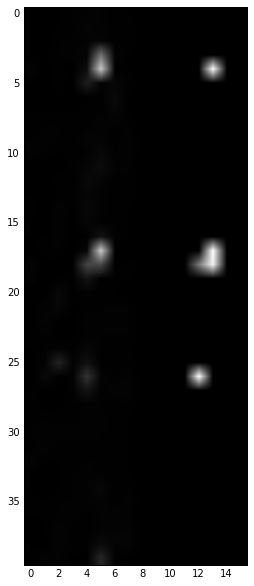

Seen 4000 examples


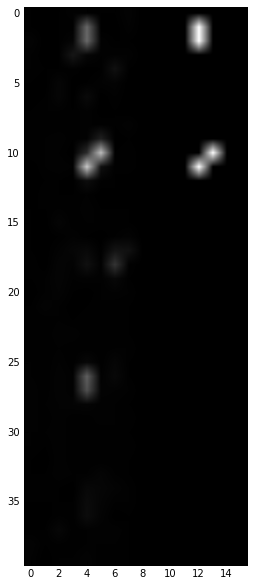

Not augmenting
Testing paths length =  1127
Finished epoch 64. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179, 0.08461269, 0.084140092, 0.08463411, 0.082187846, 0.083690181, 0.082818992, 0.084173292, 0.083927028], [0.27383068, 0.37649456, 0.43023977, 0.45243758, 0.485

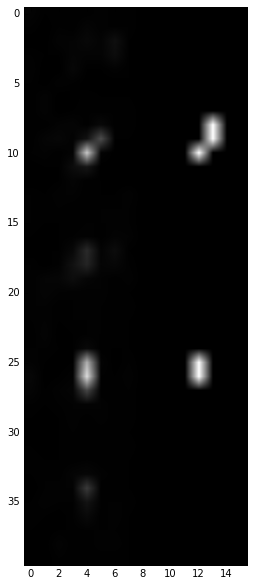

Seen 4000 examples


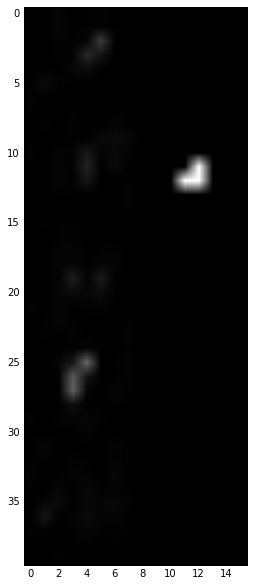

Not augmenting
Testing paths length =  1127
Finished epoch 65. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179, 0.08461269, 0.084140092, 0.08463411, 0.082187846, 0.083690181, 0.082818992, 0.084173292, 0.083927028, 0.084443405], [0.27383068, 0.37649456, 0.43023977, 0.45

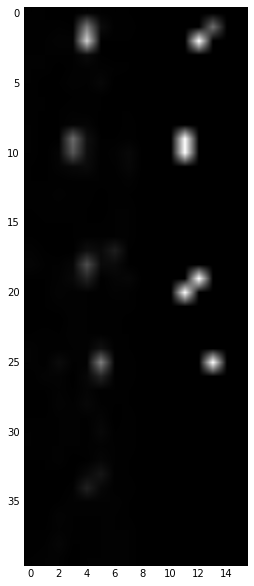

Seen 4000 examples


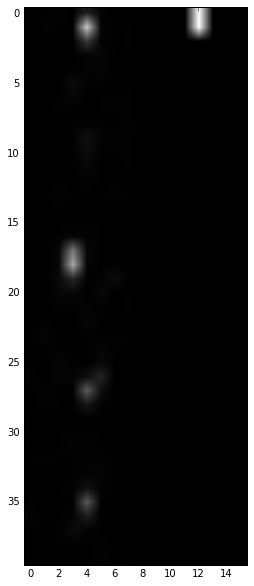

Not augmenting
Testing paths length =  1127
Finished epoch 66. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179, 0.08461269, 0.084140092, 0.08463411, 0.082187846, 0.083690181, 0.082818992, 0.084173292, 0.083927028, 0.084443405, 0.081686407], [0.27383068, 0.37649456, 0.4

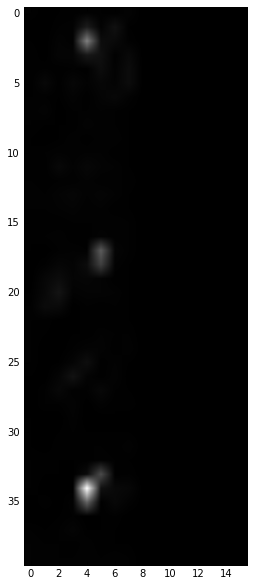

Seen 4000 examples


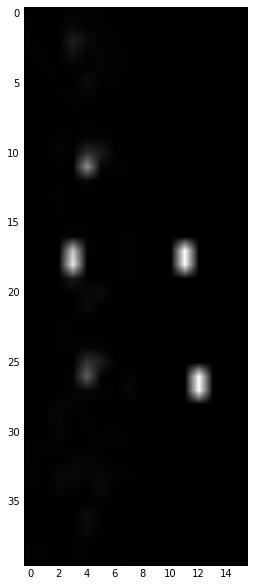

Not augmenting
Testing paths length =  1127
Finished epoch 67. Current mean loss and scores for train test are ==>
([0.42463011, 0.13801311, 0.12145194, 0.11469561, 0.10983566, 0.10555467, 0.1053817, 0.10130776, 0.10132012, 0.09899547, 0.099280186, 0.095977493, 0.095722072, 0.093843631, 0.093778729, 0.093817867, 0.093835987, 0.09171094, 0.092992105, 0.091218486, 0.091950327, 0.092031658, 0.090202786, 0.089893252, 0.090811484, 0.089939751, 0.090082034, 0.090766206, 0.089093521, 0.088520005, 0.087882742, 0.089051433, 0.088209607, 0.087827928, 0.086719111, 0.08715032, 0.087056495, 0.086327262, 0.086852141, 0.086049758, 0.085251227, 0.08665774, 0.085627988, 0.087223634, 0.085503131, 0.085780203, 0.086693421, 0.084642924, 0.086176217, 0.084285527, 0.08286535, 0.085884348, 0.086442374, 0.084489025, 0.084193558, 0.084491916, 0.082525179, 0.08461269, 0.084140092, 0.08463411, 0.082187846, 0.083690181, 0.082818992, 0.084173292, 0.083927028, 0.084443405, 0.081686407, 0.082392454], [0.27383068, 0.

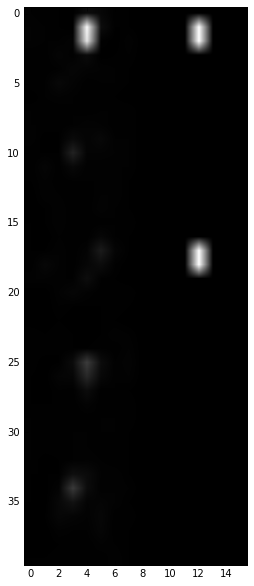

In [ ]:
if __name__ == "__main__":

    batchSize = 5
    
    learning_rate = tf.placeholder(tf.float32,shape=[])
    mse = tf.reduce_mean(tf.reduce_sum(tf.square(yPred - y_),(1,2,3))/batchSize)
    opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    opt_operation = opt.minimize(mse)
    
    diceScore = dice(yPred=yPred,yTruth=y_,thresh = 0.5)
    dataGen = dataGenerator(cvSplit = 0.8, batchSize=batchSize,inputDim=inputDim,outputDim=outputDim)
    
    epochs = 100
    
    with tf.Session() as sess:
        with tf.variable_scope("deCnn"):
            tf.initialize_all_variables().run()
            
            trainPerformance = performance()
            testPerformance = performance()
            
            # Epoch
            for epoch in xrange(epochs):
                i = 0
                trainGen = dataGen.gen(train=1)
                testGen = dataGen.gen(train=0)
                finished = 0
            
                # Training
                while finished == 0:
                    batchX, batchY, batchYOrig, finished = trainGen.next()
                    _,yPred_,loss, score = sess.run([opt_operation,yPred,mse,diceScore],feed_dict={x:batchX,y_:batchY,learning_rate:0.01})
                    trainPerformance.add(loss,score)
                    i += 1
                    if i % 400 == 0:
                        print("Seen %d examples" % (i*batchSize))
                        preds = np.vstack(tuple([row for row in yPred_.squeeze()]))
                        truth = np.vstack(tuple([row for row in batchY.squeeze()]))
                        predsTruth = np.hstack((preds,truth))
                        plt.imshow(predsTruth,cmap=cm.gray)
                        plt.show()
                        
                trainPerformance.endEpoch()     

                # Testing
                finished = 0
                while finished == 0:
                    batchX, batchY, batchYOrig, finished = testGen.next()
                    loss,score = sess.run([mse,diceScore],feed_dict={x:batchX,y_:batchY})
                    testPerformance.add(loss,score)

                testPerformance.endEpoch()

                #plt.plot(np.arange(epoch+1),trainEpochLosses,np.arange(epoch+1),testEpochLosses)
                #plt.show()

                print("Finished epoch %d. Current mean loss and scores for train test are ==>" % epoch)
                print(trainPerformance.epochLosses,trainPerformance.epochScores)
                print(testPerformance.epochLosses,testPerformance.epochScores)

    sess.close()
            